In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
file_path = '波士顿房价.csv'
df = pd.read_csv(file_path, header=0)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [4]:
# 随机选取一个特征用于画图与训练模型
# 'MEDV'为房屋价格
label = list(df.columns)
label = [i for i in label if i != 'MEDV' ]
select_label = ['NOX']
select_label.append('MEDV')
data = df[select_label]
data

,NOX,MEDV
0,0.538,24.0
1,0.469,21.6
2,0.469,34.7
3,0.458,33.4
4,0.458,36.2
...,...,...
501,0.573,22.4
502,0.573,20.6
503,0.573,23.9
504,0.573,22.0


<Axes: xlabel='NOX', ylabel='MEDV'>

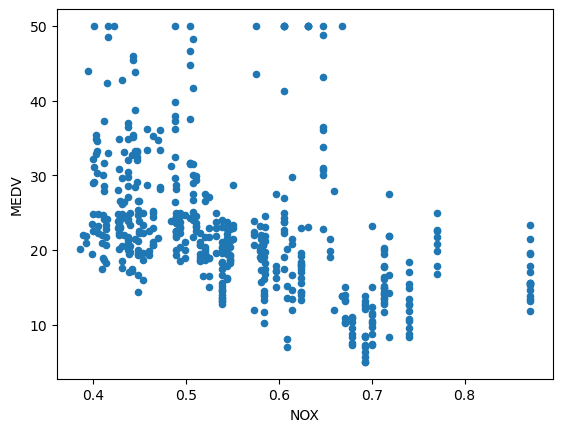

In [5]:
# 数据集的散点图
data.plot(kind='scatter',x=select_label[0],y='MEDV')

In [6]:
# 提取出数据和标签
x_data = data.drop(columns='MEDV')
y_data = data['MEDV']

In [7]:
# 将DataFrame转换为PyTorch张量
X = torch.tensor(x_data.values, dtype=torch.float32)
y = torch.tensor(y_data.values, dtype=torch.float32).reshape(-1, 1)

In [8]:
# 数据加载器
def data_iter(batch_size, data, labels):
    num_examples = len(data)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # yield是一个生成器，每次迭代时只计算当前值
        yield data[batch_indices], labels[batch_indices]

In [9]:
# 定义线性回归模型
def linear(X, a, b):
    return torch.matmul(X, a) + b
# 定义损失函数
def loss(y,y_hat):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 梯度下降
def sgd(params,lr,batch_size):
    """
    params:模型参数
    lr:学习率
    batch_size:每次读取的数据量的数量
    """
    with torch.no_grad():   # 不对梯度进行追踪，保证后续参数的更新不被影响
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()   # 清空梯度
def backwards(X,y,y_hat,a,b):
    """
    X:输入的数据
    y:真实值
    y_hat:预测值
    a:模型参数
    b:偏置值
    """
    y_hat_grad = y_hat-y
    a_grad = torch.matmul(X.T,y_hat_grad)
    b_grad = y_hat_grad.sum(dim=0)
    a.grad = a_grad
    b.grad = b_grad

In [10]:
model = linear  # 模型
lr = 0.03   # 学习率
num_epochs = 500    # 训练次数
batch_size = 10 # 一次读取的数据量

In [11]:
# 初始化模型参数
# 模型为 y = ax + b
a = torch.normal(0, 0.01, size=(len(select_label)-1,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [12]:
for epoch in range(num_epochs): #训练模型
    for X_train,y_train in data_iter(batch_size,X,y):
        y_hat = model(X_train,a,b)
        train_loss = loss(y_hat,y_train)
        backwards(X_train,y_train,y_hat,a,b)
        #backward(X,y,y_hat,a,b)
        sgd([a,b],lr,batch_size)
    with torch.no_grad():   # 模型评估
        train_l = loss(model(X,a,b), y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 52.185474
epoch 2, loss 46.678360
epoch 3, loss 46.107521
epoch 4, loss 45.709499
epoch 5, loss 45.333630
epoch 6, loss 45.016647
epoch 7, loss 44.678093
epoch 8, loss 44.370518
epoch 9, loss 44.064175
epoch 10, loss 43.783890
epoch 11, loss 43.486176
epoch 12, loss 43.212811
epoch 13, loss 42.944077
epoch 14, loss 42.744934
epoch 15, loss 42.439400
epoch 16, loss 42.260044
epoch 17, loss 41.974525
epoch 18, loss 41.755993
epoch 19, loss 41.563999
epoch 20, loss 41.296753
epoch 21, loss 41.090340
epoch 22, loss 40.894032
epoch 23, loss 40.691216
epoch 24, loss 40.538414
epoch 25, loss 40.391666
epoch 26, loss 40.187130
epoch 27, loss 40.136875
epoch 28, loss 39.816875
epoch 29, loss 39.641556
epoch 30, loss 39.482464
epoch 31, loss 39.332340
epoch 32, loss 39.181740
epoch 33, loss 39.059181
epoch 34, loss 38.900131
epoch 35, loss 38.770313
epoch 36, loss 38.635475
epoch 37, loss 38.511406
epoch 38, loss 38.387394
epoch 39, loss 38.337585
epoch 40, loss 38.182777
epoch 41,

In [13]:
# 最后一次训练得出的模型效果
for i in range(len(X)):
    y_hat = model(X[i],a,b)
    print(f'{y[i]}-{y_hat}')
print('test_loss:',loss(y,model(X,a,b)).mean())

tensor([24.])-tensor([23.0362], grad_fn=<AddBackward0>)
tensor([21.6000])-tensor([25.3767], grad_fn=<AddBackward0>)
tensor([34.7000])-tensor([25.3767], grad_fn=<AddBackward0>)
tensor([33.4000])-tensor([25.7498], grad_fn=<AddBackward0>)
tensor([36.2000])-tensor([25.7498], grad_fn=<AddBackward0>)
tensor([28.7000])-tensor([25.7498], grad_fn=<AddBackward0>)
tensor([22.9000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([27.1000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([16.5000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([15.])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([18.9000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([21.7000])-tensor([23.5111], grad_fn=<AddBackward0>)
tensor([20.4000])-tensor([23.0362], grad_fn=<AddBackward0>)
tensor([18.2000])-tensor([23.0362], grad_fn=<AddBackward0>)
tensor([19.9000])-tensor([23.0362], grad_fn=<AddBackward0>)
tensor([23.1000])-tensor([23.0362], grad_fn=<Add

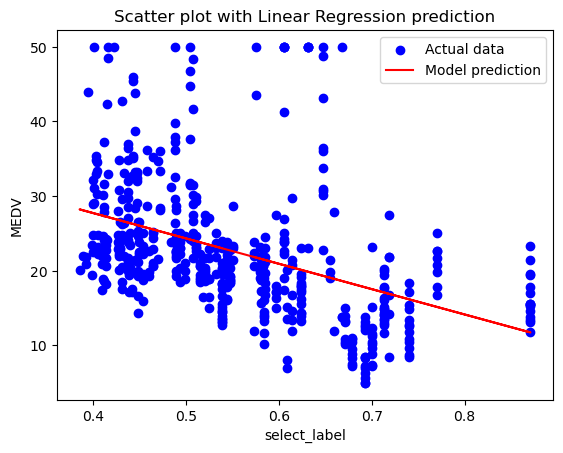

In [14]:
# 预测结果
y_pred = model(X,a,b).detach().numpy()
# 绘制散点图
plt.scatter(data[select_label[0]], data['MEDV'], color='blue', label='Actual data')
# 绘制模型的预测线
plt.plot(X, y_pred, color='red', label='Model prediction')
# 添加标题和图例
plt.title('Scatter plot with Linear Regression prediction')
plt.xlabel('select_label')
plt.ylabel('MEDV')
plt.legend()
# 显示图表
plt.show()

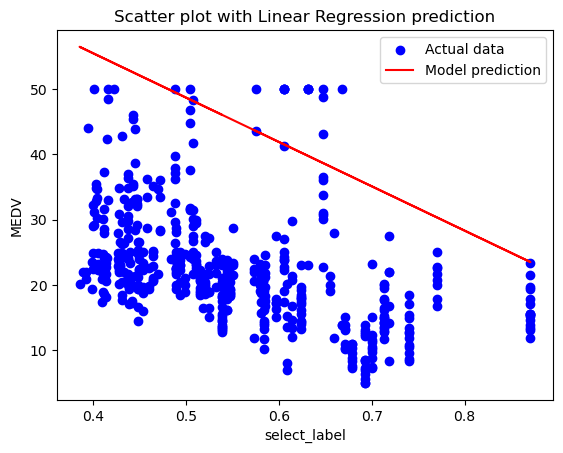

In [15]:
# 预测结果
y_pred1 = model(X,2*a,2*b).detach().numpy()
# 绘制散点图
plt.scatter(data[select_label[0]], data['MEDV'], color='blue', label='Actual data')
# 绘制模型的预测线
plt.plot(X, y_pred1, color='red', label='Model prediction')
# 添加标题和图例
plt.title('Scatter plot with Linear Regression prediction')
plt.xlabel('select_label')
plt.ylabel('MEDV')
plt.legend()
# 显示图表
plt.show()